In [18]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [19]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[5.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])
Ecutoff=0.04

effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTxC,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTxC(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),0.0,[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTxC(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),0.0,[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTxC(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),Ecutoff,[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTxC(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),Ecutoff,[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [20]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 33.932306 seconds (219.72 M allocations: 42.313 GiB, 11.77% gc time)


3.0

In [21]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [22]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=1/2*15.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [23]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,0.0)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [24]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,0.0)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [25]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,0.0)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [26]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.0
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

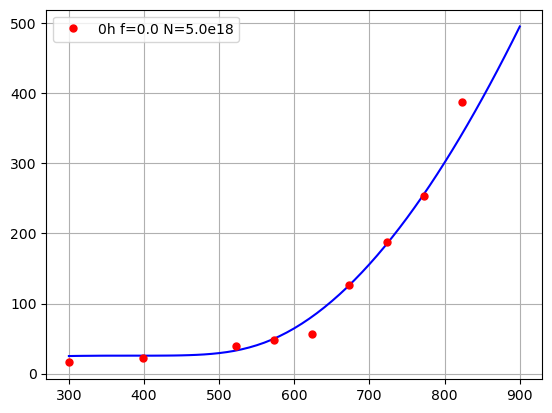

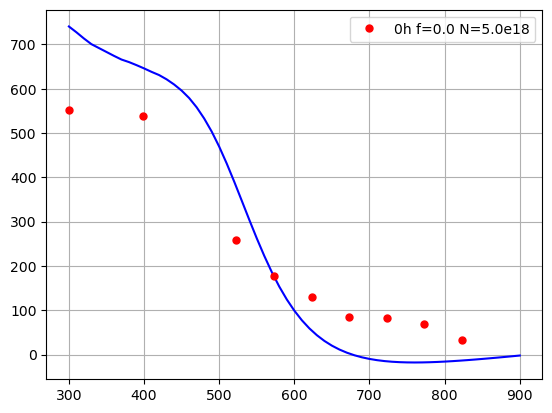

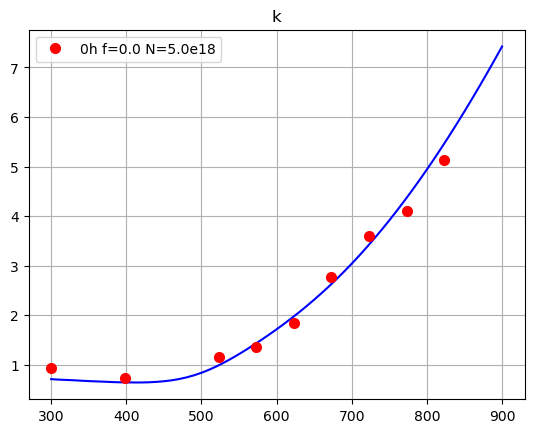

In [27]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hECE,linestyle="None",marker=".",
    markersize=10,color="r",label=string("0h f=$f N=$(numofn[1])"))
grid()
legend(loc="upper left")
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hSCS,linestyle="None",marker=".",
    markersize=10,color="r",label=string("0h f=$f N=$(numofn[1])"))
grid()
legend(loc="upper right")
figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn0hKCK,linestyle="None",marker="o",
    markersize=7,color="r",label=string("0h f=$f N=$(numofn[1])"))

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [28]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [29]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

0.7127311118127044
0.7032916625366681
0.6965308809178
0.6901995284348745
0.6811608699854528
0.6734817940916462
0.6671456079969125
0.6615340505867927
0.6544199547204809
0.6497249537129673
0.6468023102710097
0.6457604291615979
0.6454740419765718
0.6494541924276965
0.6575001956782043
0.6699985675008167
0.6883027473828932
0.713903755055838
0.7474316287331926
0.7894993589523448
0.8407625591427188
0.9010175342941376
0.9696803000842562
1.0463848006184573
1.1293863807217572
1.2176213161040994
1.3102004066477042
1.4073903836225634
1.5074530136475102
1.610711737222053
1.7176784225413357
1.8286806773887507
1.9433175015826447
2.0622059582290246
2.186249908767798
2.3151795372723174
2.449105718892647
2.58839167653473
2.7338571530691795
2.884801262434931
3.0414568599589193
3.2039971584414517
3.3731363815009323
3.5479382881764363
3.7286891746711675
3.9154533602934287
4.1088644650783515
4.307878902110679
4.512810104240922
4.723919083168128
4.940996283993649
5.163743318149994
5.3922230725309745
5.626723

In [30]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

2513.3150681660713
2533.0242174612763
2544.593821791291
2551.978011798399
2561.825325424673
2567.230310133759
2568.6318888211295
2567.879306911481
2571.0800832218297
2570.6061022424838
2569.2290685031576
2568.5212008291896
2574.4975634632456
2580.698921667808
2591.536090466828
2611.3137528682764
2642.066618897774
2684.6752226684957
2744.05368578529
2827.451206076311
2936.5916198675704
3076.3404741997506
3252.45791930475
3473.9609031705436
3740.11363572451
4055.781121390888
4424.455796271495
4854.029569129521
5337.62149062504
5878.402035597103
6479.210656282015
7140.746170640008
7857.510126309985
8630.838635398022
9464.940066504758
10354.793434665738
11298.39394688433
12296.346685507579
13354.334739755262
14463.885266623383
15625.56275534602
16839.77260391216
18113.105490691254
19434.8706864184
20807.41679551347
22230.975968538813
23712.44963631853
25239.913662759995
26816.797735323198
28446.172983566386
30125.756111295115
31852.214519852285
33626.49990387313
35452.350854462995
37324.60

In [31]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-740.4202350781324
-727.3382912820289
-713.3151876410599
-700.4698134490222
-691.6966729984819
-682.9199479537424
-674.1108278012069
-665.8129010629538
-660.0480777743346
-653.1771054679194
-645.843729012237
-638.0134235940677
-630.8163079891591
-621.2068475485169
-609.5560132031876
-595.7850986097882
-578.9823131862547
-558.0606349041068
-532.8327518804293
-503.36065781369547
-469.309174803317
-431.25411558689405
-390.2131608460851
-347.46274064710065
-304.3825643324097
-262.4239995036466
-222.77752458285613
-186.18539916213498
-153.33391312594358
-124.36319198565992
-99.17090065663619
-77.53375906391011
-59.208762458756524
-43.803170405292704
-30.910405111482067
-20.23489859644358
-11.468812280303528
-4.322332657828211
1.473476429072954
6.087963342952065
9.707884569243477
12.489027356871642
14.57314344817833
16.046751164940066
17.00936867432157
17.540326367055133
17.71057690352623
17.566815306041104
17.160426248855995
16.532769110573064
15.717273196731943
14.743399675777994
13.636713

In [32]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

-0.14187114637048678
-0.13459118302302592
-0.12531154947619197
-0.11629538857166143
-0.11071071995151645
-0.10453192117353227
-0.09784404584449494
-0.09137355700825388
-0.08754820170683998
-0.08263119594646734
-0.07758077508784317
-0.07269863184340163
-0.06982305319591796
-0.06587411918046966
-0.06190109237526573
-0.05861045020223646
-0.05569158466665084
-0.05237286724445334
-0.0490171980495555
-0.046326223461529634
-0.04340284257668725
-0.04019523299109516
-0.03681489092062609
-0.03384768632456736
-0.030299482327480587
-0.02632150796774335
-0.021927822573800604
-0.01760178264004003
-0.012402022407185243
-0.00654829183985467
-0.0001793288481768407
0.0067438463540759885
0.014614414162466116
0.02334191514126105
0.03272256786426342
0.043053232640782424
0.05443575918786492
0.06684745657731639
0.08007048596559552
0.0944877999945013
0.11008505091434384
0.12686141939165996
0.14460307449254084
0.16371774999803868
0.18413386244730057
0.20585893619213302
0.22869415533408577
0.25303617219048924
0

In [33]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

3.861112620664078e-5
7.917490082043799e-5
0.00015386080568710714
0.00028702159778810666
0.0005229330318206387
0.0009178693757568618
0.0015567862868005394
0.0025657071048164116
0.004163953295804737
0.006555771921957645
0.0100724861100887
0.015144247012378551
0.02250418342703837
0.03260343779243531
0.04631038870742561
0.06473750590524807
0.08894668457835132
0.11967589444440578
0.15793610922630993
0.20505941295997998
0.2608211430913104
0.3249819609186601
0.3970848956553816
0.4773646100576811
0.5630964920844624
0.6533815641471199
0.7473575526582175
0.8457867781542286
0.9460012591199851
1.0485552097781767
1.1541096885513007
1.2629632272664595
1.3743310237860624
1.4889294767144499
1.6078746253953702
1.7306077329591847
1.8571453291663715
1.987880418733408
2.123857281853523
2.2639984063234513
2.408556969489097
2.557712644552462
2.712398812209113
2.8712765264363593
3.0347084149082444
3.2027557558082194
3.3762552186574184
3.553770562544599
3.7357177495701466
3.9224373595183795
4.113640521570838


In [34]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

0.8545636470569846
0.8378036706588735
0.8216885695883048
0.8062078954087478
0.7913486569051487
0.7770958458894216
0.7634328675546068
0.7503419004902302
0.7378042031315161
0.725800377737477
0.714310599248764
0.703314813992621
0.6927929117454513
0.6827248738157309
0.6730908993460444
0.663871511797805
0.6550476474711927
0.6466007278558856
0.6385127175564381
0.6307661694538944
0.6233442586280957
0.6162308063665727
0.6094102953495008
0.6028678768853436
0.5965893709647754
0.5905612599247229
0.5847706765632873
0.5792053881083747
0.5738537769347103
0.568704819283731
0.5637480628382119
0.5589736037682154
0.5543720636341162
0.5499345663733138
0.5456527155081643
0.5415185716723504
0.5375246305384104
0.5336638012240055
0.5299293852500612
0.5263150561169784
0.5228148395554788
0.5194230944973298
0.5161344947992782
0.5129440117420382
0.5098468973156226
0.5068386682930764
0.5039150910868471
0.501072167375591
0.4983061204840497
0.495613382494646
0.4929905820664207
0.49043453293479566
0.4879422230641740